# Mini Project 2: Word2Vec vs GloVe

In [13]:

# Fix Colab binary mismatch (numpy / pandas / gensim / sklearn issues)
!pip install --upgrade --force-reinstall numpy pandas scikit-learn gensim seaborn matplotlib


  Using cached numpy-2.3.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pandas-2.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached scikit_learn-1.7.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached gensim-4.3.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.6-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached scipy-1.16.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (61 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached thread

In [1]:

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA


## Load Dataset

In [2]:

# Upload your CSV to Colab
from google.colab import files
uploaded = files.upload()

# Replace with your filename if different
df = pd.read_csv("Product_Reviews.csv")
print(df.shape)
df.head()


Saving Product_Reviews.csv to Product_Reviews (1).csv
(1007, 3)


,Product ID,Product Review,Sentiment
0,AVpe7AsMilAPnD_xQ78G,I initially had trouble deciding between the p...,POSITIVE
1,AVpe7AsMilAPnD_xQ78G,Allow me to preface this with a little history...,POSITIVE
2,AVpe7AsMilAPnD_xQ78G,I am enjoying it so far. Great for reading. Ha...,POSITIVE
3,AVpe7AsMilAPnD_xQ78G,I bought one of the first Paperwhites and have...,POSITIVE
4,AVpe7AsMilAPnD_xQ78G,I have to say upfront - I don't like coroporat...,POSITIVE


## Data Exploration

Sentiment
POSITIVE    852
NEUTRAL      81
NEGATIVE     74
Name: count, dtype: int64


/tmp/ipython-input-3833931379.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Sentiment", data=df, palette="Set2")


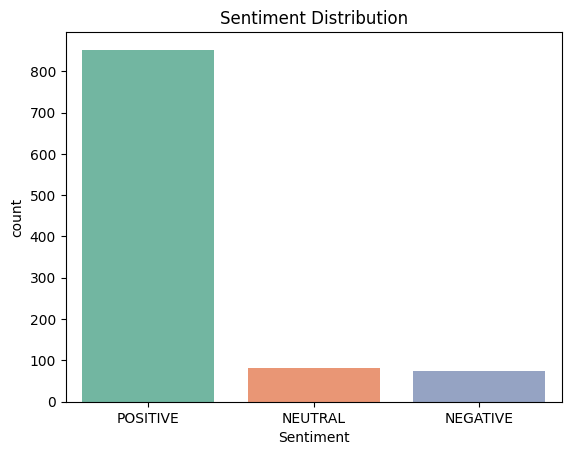

In [3]:

print(df["Sentiment"].value_counts())

sns.countplot(x="Sentiment", data=df, palette="Set2")
plt.title("Sentiment Distribution")
plt.show()


In [4]:
df.isnull().sum()

,0
Product ID,0
Product Review,0
Sentiment,0


In [6]:
# checking for duplicate values
df.duplicated().sum()

2

In [8]:
# dropping duplicate values
df = df.drop_duplicates()

df.duplicated().sum()

0

#EDA

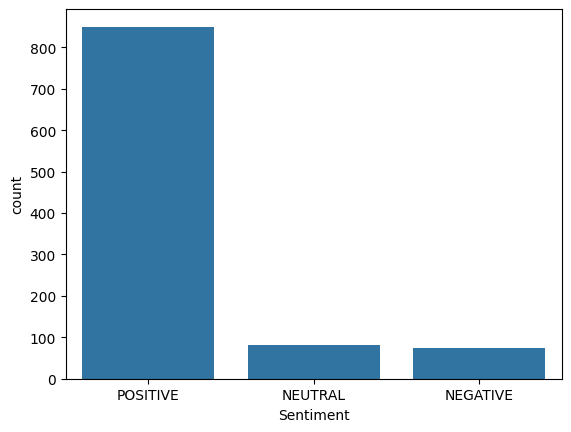

In [10]:
sns.countplot(data=df, x="Sentiment");

In [12]:
df['Sentiment'].value_counts(normalize=True)

,proportion
Sentiment,
POSITIVE,0.845771
NEUTRAL,0.080597
NEGATIVE,0.073632


## Text Preprocessing

In [13]:

stop_words = set([
    "the","a","an","is","it","this","that","in","on","and","or","of",
    "to","for","with","as","was","were","by","be","are","at","from"
])

def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z]", " ", str(text))
    text = text.lower()
    tokens = [w for w in text.split() if w not in stop_words and len(w) > 2]
    return tokens

df["tokens"] = df["Product Review"].apply(preprocess_text)
df.head()


,Product ID,Product Review,Sentiment,tokens
0,AVpe7AsMilAPnD_xQ78G,I initially had trouble deciding between the p...,POSITIVE,"[initially, had, trouble, deciding, between, p..."
1,AVpe7AsMilAPnD_xQ78G,Allow me to preface this with a little history...,POSITIVE,"[allow, preface, little, history, casual, read..."
2,AVpe7AsMilAPnD_xQ78G,I am enjoying it so far. Great for reading. Ha...,POSITIVE,"[enjoying, far, great, reading, had, original,..."
3,AVpe7AsMilAPnD_xQ78G,I bought one of the first Paperwhites and have...,POSITIVE,"[bought, one, first, paperwhites, have, been, ..."
4,AVpe7AsMilAPnD_xQ78G,I have to say upfront - I don't like coroporat...,POSITIVE,"[have, say, upfront, don, like, coroporate, he..."


In [14]:
# Show a few random examples of original vs cleaned text
sample = df[["Product Review", "tokens"]].sample(5, random_state=42)

for i, row in sample.iterrows():
    print("Original:", row["Product Review"])
    print("Cleaned :", row["tokens"])
    print("-" * 80)


Original: This is a good alternative to the amazon echo. I like that supposedly it's not listening all the time and you have to hit the button to talk to Alexa but at the same time you have to hit the button to talk to Alexa.
Cleaned : ['good', 'alternative', 'amazon', 'echo', 'like', 'supposedly', 'not', 'listening', 'all', 'time', 'you', 'have', 'hit', 'button', 'talk', 'alexa', 'but', 'same', 'time', 'you', 'have', 'hit', 'button', 'talk', 'alexa']
--------------------------------------------------------------------------------
Original: I bought this as a gift for Christmas and it was well liked
Cleaned : ['bought', 'gift', 'christmas', 'well', 'liked']
--------------------------------------------------------------------------------
Original: I own the Echo, and love the product! So I purchased the Tap as a gift.
Cleaned : ['own', 'echo', 'love', 'product', 'purchased', 'tap', 'gift']
--------------------------------------------------------------------------------
Original: It's ve

In [24]:
df["cleaned_text"] = df["tokens"].apply(lambda x: " ".join(x))

#WORD2VEC

In [17]:
from gensim.models import Word2Vec
import numpy as np
import pandas as pd

# Step 1 — Use your tokens column
sentences = df["tokens"]

# Step 2 — Train CBOW Model
cbow_model = Word2Vec(
    sentences,
    vector_size=100,
    window=3,
    min_count=5,
    sg=0,  # CBOW
    workers=4
)

# Step 3 — Train Skip-gram Model
skipgram_model = Word2Vec(
    sentences,
    vector_size=100,
    window=3,
    min_count=5,
    sg=1,  # Skip-gram
    workers=4
)

# Step 4 — Function to get sentence vectors
def get_sentence_vector(model, tokens):
    word_vecs = [model.wv[word] for word in tokens if word in model.wv]
    if len(word_vecs) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vecs, axis=0)

# Step 5 — Apply to dataset
cbow_vectors = np.array([get_sentence_vector(cbow_model, tokens) for tokens in sentences])
skipgram_vectors = np.array([get_sentence_vector(skipgram_model, tokens) for tokens in sentences])

# Step 6 — Optional: store in DataFrames
df_cbow = pd.DataFrame(cbow_vectors)
df_skipgram = pd.DataFrame(skipgram_vectors)

print("CBOW shape:", df_cbow.shape)
print("Skip-gram shape:", df_skipgram.shape)


CBOW shape: (1005, 100)
Skip-gram shape: (1005, 100)


In [18]:
df_cbow.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.077945,0.219130,0.056233,-0.023601,0.160462,-0.311862,0.172887,0.598181,-0.303708,-0.146340,...,0.249240,0.066899,-0.020342,-0.038306,0.535453,0.258317,0.181624,-0.328494,0.236036,-0.072375
1,-0.076840,0.224471,0.059848,-0.023362,0.163432,-0.322055,0.179449,0.615704,-0.310792,-0.150251,...,0.255684,0.068445,-0.023289,-0.039090,0.552129,0.265680,0.188687,-0.337677,0.242599,-0.071787
2,-0.064654,0.225094,0.066229,-0.022556,0.173862,-0.335795,0.192246,0.642551,-0.321284,-0.146310,...,0.261373,0.065209,-0.028472,-0.034431,0.583779,0.279870,0.194381,-0.352546,0.253880,-0.073565
3,-0.078972,0.230629,0.058231,-0.024491,0.169203,-0.330766,0.185210,0.636445,-0.322242,-0.151362,...,0.265363,0.070736,-0.021654,-0.039076,0.570440,0.273412,0.196017,-0.349443,0.252388,-0.077104
4,-0.086014,0.244672,0.060422,-0.024922,0.176883,-0.345774,0.193192,0.665508,-0.339210,-0.163164,...,0.278478,0.074022,-0.023762,-0.041037,0.593749,0.284866,0.203526,-0.365645,0.263727,-0.081701


In [19]:
# Checking top 5 similar words to the word 'book' by cbow_model & skipgram_model
print("CBOW:",cbow_model.wv.similar_by_word('book', topn=5))
print("SkipGram:",skipgram_model.wv.similar_by_word('book', topn=5))


CBOW: [('oasis', 0.9992333650588989), ('start', 0.9992049336433411), ('before', 0.9992026090621948), ('reviews', 0.9991999864578247), ('text', 0.9991982579231262)]
SkipGram: [('reading', 0.9700673818588257), ('experience', 0.9486857056617737), ('reviews', 0.9478694200515747), ('buying', 0.9476591944694519), ('especially', 0.9413362145423889)]


#Glove

In [22]:
# 1. Download GloVe from Stanford
!wget http://nlp.stanford.edu/data/glove.6B.zip

# 2. Unzip it
!unzip glove.6B.zip -d glove.6B

# 3. Convert GloVe format → word2vec format (needed for gensim)
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = "glove.6B/glove.6B.100d.txt"   # <-- THIS is the correct path
word2vec_output_file = "glove.6B.100d.word2vec"
glove2word2vec(glove_input_file, word2vec_output_file)

# 4. Load with gensim
from gensim.models import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

# 5. Test the model
print("Vector for 'phone':", glove_model["phone"][:10])  # show first 10 dimensions
print("Most similar to 'phone':", glove_model.most_similar("phone"))


--2025-09-02 17:19:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-09-02 17:19:54--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-09-02 17:19:54--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

/tmp/ipython-input-1104033213.py:11: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


Vector for 'phone': [ 3.1764e-02 -6.0768e-01  5.2233e-01 -1.1533e-02  3.6009e-01  3.6460e-01
 -4.9728e-03 -3.3769e-04  6.6011e-01 -1.2602e-01]
Most similar to 'phone': [('telephone', 0.9113394021987915), ('cellphone', 0.8122148513793945), ('phones', 0.8030568957328796), ('mobile', 0.7307462692260742), ('mail', 0.7292180061340332), ('internet', 0.7269454002380371), ('messages', 0.7129441499710083), ('wireless', 0.7091723084449768), ('telephones', 0.7049247622489929), ('cellular', 0.6969102621078491)]


In [30]:

import numpy as np
words = glove_model.index_to_key
word_vector_dict = dict(zip(glove_model.index_to_key, list(glove_model.vectors)))
vec_size = 100

def average_vectorizer_GloVe(doc):
    feature_vector = np.zeros((vec_size,), dtype="float64")
    tokens = doc.split()
    words_in_vocab = [word for word in tokens if word in words]
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])
    if len(words_in_vocab) != 0:
        feature_vector = feature_vector / len(words_in_vocab)
    return feature_vector

# Feature matrix
df_glove = pd.DataFrame(
    df['final_cleaned_text'].apply(average_vectorizer_GloVe).tolist(),
    columns=['Feature '+str(i) for i in range(vec_size)]
)
print("Feature matrix shape:", df_glove.shape)


# ================== 4. Train & Evaluate Classifier ==================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Labels
y = df['Sentiment'].apply(lambda x: 1 if x == "POSITIVE" else 0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df_glove, y, test_size=0.2, random_state=42)

# Train Random Forest
clf_glove = RandomForestClassifier(n_estimators=100, random_state=42)
clf_glove.fit(X_train, y_train)

# Predictions
y_pred = clf_glove.predict(X_test)

# Results
print("Accuracy (Pretrained GloVe):", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["NEGATIVE", "POSITIVE"]))


                                      Product Review  \
0  I initially had trouble deciding between the p...   
1  Allow me to preface this with a little history...   
2  I am enjoying it so far. Great for reading. Ha...   
3  I bought one of the first Paperwhites and have...   
4  I have to say upfront - I don't like coroporat...   

                                  final_cleaned_text  
0  initially had trouble deciding between paperwh...  
1  allow preface little history casual reader who...  
2  enjoying far great reading had original fire s...  
3  bought one first paperwhites have been very pl...  
4  have say upfront don like coroporate hermetica...  
Feature matrix shape: (1005, 100)
Accuracy (Pretrained GloVe): 0.8905472636815921

Classification Report:
               precision    recall  f1-score   support

    NEGATIVE       1.00      0.19      0.31        27
    POSITIVE       0.89      1.00      0.94       174

    accuracy                           0.89       201
   macro

##THANKS!!
